# Práctica 5 : Regresión logística


Un clásico en los cursos de Machine learning es utilizar los datos del Titanic para realizar un modelo que prediga (a posteriori, claro) las posibilidades de sobrevivir al naufragio a partir de datos como la edad, el sexo, lo que se ha pagado por el pasaje, etc. 

Aquí utilizaremos regresión logística para intentar predecir este valor.



In [1]:
# Curso: TDM - 2023/2024
# Nombre: Daniel Mihai
# Apellidos: Rece
# Fecha: 14-11-2023

## Preparando el entorno

Empezamos asegurándonos de que Spark está disponible y funciona y cargando funciones auxiliares

In [2]:
import findspark
findspark.init()

import urllib
import pyspark                         # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext                        # para trabajar con RDD's

df = spark.sql('''select 'spark' as hola ''')
df.show()

23/11/14 19:07:47 WARN Utils: Your hostname, danrec-HP-Pavilion-Gaming-Laptop-15-ec0xxx resolves to a loopback address: 127.0.1.1; using 10.8.93.156 instead (on interface wlo1)
23/11/14 19:07:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/11/14 19:07:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
+-----+
| hola|
+-----+
|spark|
+-----+



## Funciones útiles 

A continuación se proporcionan algunas de las funciones que han apareceido en notebooks anteriores y que nos pueden ser útiles ahora.

In [5]:
########
# Dibujamos mediante histograma la distribución de una varaible numérica del dataframe
########
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
%matplotlib inline
import pyspark.sql.functions as func 

def histogram(df,col,bins=20,color="red"):
    """
    df: dataframe
    col: name of dataframe column
    """
    fig,ax = plt.subplots()
    hist(ax, df.select([col]), bins = bins,  color=[color])
    plt.xlabel(col)
    vs = df.select(func.mean(col),func.stddev(col)).collect()
    mean = vs[0][0]
    sd = vs[0][1]
    median = df.agg(func.percentile_approx(col, 0.5).alias("median")).collect()[0][0]
    #print(mean,sd,median,mode)
    plt.plot([mean-1.97*sd,mean+1.97*sd],[10,10],color="blue")
    plt.plot([mean,mean],[0,-20],color="blue")
    plt.plot([median,median],[25,-15],color="green")
    plt.title("Histogram of "+str(col)+". Median: "+str(round(median,2))+". Mean: "+str(round(mean,2))+". SD: "+str(round(sd,2)))
    plt.show()


########
# Creación del dataframe a partir de un ficheroE
########
def create_spark_dataframe(file):
    df = spark.read.format("com.databricks.spark.csv").options(header='true', inferschema='true').load(file)
    return df



## Carga de datos

In [6]:
# primero lo descargamos en local

url = "https://raw.githubusercontent.com/ygarciar/Datasets/main/titanicyesno.csv"
file = "./titanicyesno.csv"
urllib.request.urlretrieve(url,file)

# ahora llamamos a la función
df = create_spark_dataframe(file)

## Ejercicios

A continuación se describe cada una de las columnas del dataframe:

* `survived` - Survival ('yes' or 'no')
* `pclass` - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* `name` - Name
* `sex` - Sex
* `age` - Age
* `sibsp` - Number of Siblings/Spouses Aboard
* `parch` - Number of Parents/Children Aboard
* `ticket` - Ticket Number
* `fare` - Passenger Fare
* `embarked` - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)


Se pide: predecir el valor de la columna `survided` a partir de las columnas: 
`pclass`, `sex`, `age`, `sibsp`, `parch`, `fare`.

### Pregunta 1

Escribe las instrucciones necesarias para visualizar el esquema del dataframe, el número de filas cargadas y los primeros estadísticos

In [17]:
# Sol:
df.printSchema()
print(f"Nº de filas cargadas = {df.count()} \n")
df.describe().show()


root
 |-- survived: string (nullable = true)
 |-- pclass: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sibsp: integer (nullable = true)
 |-- parch: integer (nullable = true)
 |-- ticket: string (nullable = true)
 |-- fare: double (nullable = true)
 |-- embarked: string (nullable = true)

Nº de filas cargadas = 891 

+-------+--------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+--------+
|summary|survived|            pclass|                name|   sex|               age|             sibsp|              parch|            ticket|             fare|embarked|
+-------+--------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+--------+
|  count|     891|               891|                 891|   891|               



### Pregunta 2

Visualiza las primeras 5 filas de la tabla:

In [18]:
# Sol:
df.head(5)

[Row(survived='no', pclass=3, name='Braund, Mr. Owen Harris', sex='male', age=22.0, sibsp=1, parch=0, ticket='A/5 21171', fare=7.25, embarked='S'),
 Row(survived='yes', pclass=1, name='Cumings, Mrs. John Bradley (Florence Briggs Thayer)', sex='female', age=38.0, sibsp=1, parch=0, ticket='PC 17599', fare=71.2833, embarked='C'),
 Row(survived='yes', pclass=3, name='Heikkinen, Miss. Laina', sex='female', age=26.0, sibsp=0, parch=0, ticket='STON/O2. 3101282', fare=7.925, embarked='S'),
 Row(survived='yes', pclass=1, name='Futrelle, Mrs. Jacques Heath (Lily May Peel)', sex='female', age=35.0, sibsp=1, parch=0, ticket='113803', fare=53.1, embarked='S'),
 Row(survived='no', pclass=3, name='Allen, Mr. William Henry', sex='male', age=35.0, sibsp=0, parch=0, ticket='373450', fare=8.05, embarked='S')]

 Las columnas `survived` y `sex` son de tipo string. Para crear un modelo de regresión logística necesitamos que ambas sean de tipo numérico. Para convertirlos a número utilizaremos el método [StringIndexer](https://spark.apache.org/docs/latest/ml-features#stringindexer). Un ejemplo que puede ayudar a entender cómo funciona:

In [19]:
# Ejemplo:
from pyspark.ml.feature import StringIndexer
dfPega = spark.createDataFrame(
    [(0, "a"), (1, "b"), (2, "c"), (3, "a"), (4, "a"), (5, "c")],
    ["id", "category"])
dfPega.show()


+---+--------+
| id|category|
+---+--------+
|  0|       a|
|  1|       b|
|  2|       c|
|  3|       a|
|  4|       a|
|  5|       c|
+---+--------+



In [23]:
indexer = StringIndexer(inputCol="category", outputCol="categoryIndex") # método
indexed_model = indexer.fit(dfPega) # metodo.fit --> modelo
df_indexed = indexed_model.transform(dfPega)  # modelo.transform --> resultado
df_indexed.show()

+---+--------+-------------+
| id|category|categoryIndex|
+---+--------+-------------+
|  0|       a|          0.0|
|  1|       b|          2.0|
|  2|       c|          1.0|
|  3|       a|          0.0|
|  4|       a|          0.0|
|  5|       c|          1.0|
+---+--------+-------------+



__a)__ Utiliza `StringIndexer` con columna de entrada `survived` y como columna de salida `label_survived`. El modelo (obtenido tras hacer fit) se llamará `indexer_model`. 

__b)__ Utiliza `StringIndexer` con columna de entrada `sex`  y como columna de salida `sex_i`. El dataframe que se obtiene tras aplicar los dos indexers se llamará `dfi`.

__c)__ Mostrar las primeras 5 filas del dataframe `dfi`.

__Notas__:

* Ponerle un nombre diferente tanto a cada método indexer como al "modelo" que generan, no reutilizar variables. 


In [35]:
#Sol: 
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="survived", outputCol="label_survived") 
indexer_model = indexer.fit(df)
df_indexed = indexer_model.transform(df)
indexer_sex = StringIndexer(inputCol="sex", outputCol= "sex_i")
indexer_sex_model = indexer_sex.fit(df_indexed)
dfi = indexer_sex_model.transform(df_indexed)
dfi.show(5)

+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+--------------+-----+
|survived|pclass|                name|   sex| age|sibsp|parch|          ticket|   fare|embarked|label_survived|sex_i|
+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+--------------+-----+
|      no|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|           0.0|  0.0|
|     yes|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|           1.0|  1.0|
|     yes|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|           1.0|  1.0|
|     yes|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1|       S|           1.0|  1.0|
|      no|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05|       S|           0.0|  0.0|
+--------+------+--------------------+------+----+-----+

Este código muestra la identificación entre etiquetas y valores en el caso de la columna `label_survived`, y el dataframe resultante.
Cuidado: los valores asignados a las etiquetas pueden cambiar con respecto a este notebook, apuntarlos para más adelante.

In [36]:
print(list(zip(indexer_model.labels,[0,1])))

[('no', 0), ('yes', 1)]


In [37]:
print(list(zip(indexer_sex_model.labels,[0,1])))

[('male', 0), ('female', 1)]


### Pregunta 3

Estudiar los valores nulos de las columnas que hay en el dataframe `dfi`:

In [47]:
# Sol:
import pyspark.sql.functions as F
(dfi.agg(*[F.sum(F.col(c).isNull().cast("int")).alias(c) for c in dfi.columns])).show()


+--------+------+----+---+---+-----+-----+------+----+--------+--------------+-----+
|survived|pclass|name|sex|age|sibsp|parch|ticket|fare|embarked|label_survived|sex_i|
+--------+------+----+---+---+-----+-----+------+----+--------+--------------+-----+
|       0|     0|   0|  0|177|    0|    0|     0|   0|       2|             0|    0|
+--------+------+----+---+---+-----+-----+------+----+--------+--------------+-----+



La columna `embarked` no la vamos a usar, pero `age` sí, y son muchos nulos. Decidimos rellenar estos valores con la media. Afortunadamente disponemos ya de un transformador que hace eso, llamado `Imputer` (ver [aquí](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Imputer.html)). Por defecto ya rellena con la media como muestra este ejemplo:

In [48]:
from pyspark.ml.feature import Imputer

dfPega = spark.createDataFrame([
    (1.0, float("nan")),
    (2.0, float("nan")),
    (float("nan"), 3.0),
    (4.0, 4.0),
    (5.0, 5.0)
], ["a", "b"])
dfPega.show()

imputer = Imputer(inputCols=["a", "b"], outputCols=["out_a", "out_b"]) # metodo
imputmodel = imputer.fit(dfPega) # metodo.fit -> modelo

imputmodel.transform(dfPega).show()  # modelo.transform --> resultado

+---+---+
|  a|  b|
+---+---+
|1.0|NaN|
|2.0|NaN|
|NaN|3.0|
|4.0|4.0|
|5.0|5.0|
+---+---+

+---+---+-----+-----+
|  a|  b|out_a|out_b|
+---+---+-----+-----+
|1.0|NaN|  1.0|  4.0|
|2.0|NaN|  2.0|  4.0|
|NaN|3.0|  3.0|  3.0|
|4.0|4.0|  4.0|  4.0|
|5.0|5.0|  5.0|  5.0|
+---+---+-----+-----+



__a)__ Aplicar el método `Imputer` usando la columna `age` como entrada, generando una nueva columna `age_m`. La nueva columna no tiene nulos, ya que han sido sustituidos por la media de los valores existentes. 

Llamaremos a la columna de salida `age_m`, y al dataframe de salida `df_m`. Muestra 5 filas del nuevo dataframe.

In [52]:
# Sol: 
from pyspark.ml.feature import Imputer

imputer_age = Imputer(inputCol="age", outputCol="age_m")
imputmodel_age = imputer_age.fit(dfi) 
df_m = imputmodel_age.transform(dfi)

__b)__ Comprueba que el nuevo dataframe `df_m` no tiene nulos en la columna `age_m`.

In [54]:
# Sol: 
df_m.where(F.col("age_m").isNull()).count()

0

### Pregunta 4

Comenzamos con la preparación de los datos para la construcción del modelo. El objetivo es predecir el valor de la columna `survided` a partir de las columnas: `pclass`, `sex`, `age`, `sibsp`, `parch`, `fare`.

Se pide: combinar en un `VectorAssembler` las columnas `pclass`, `age_m`, `sibsp`, `parch`, `fare`, `sex_i` dando como salida una nueva columna `features`. Este transformador tomará el dataframe `df_m` como entrada. El dataframe de salida se debe llamar `df_feat`.



In [58]:
# Sol:
from pyspark.ml.feature import VectorAssembler

vec_ass = VectorAssembler(inputCols=["pclass", "age_m", "sibsp", "parch", "fare", "sex_i"], outputCol= "features")
df_feat = vec_ass.transform(df_m)

La ejecución del siguiente código deja solo las columnas que queremos y muestra el resultado:

In [59]:
df_feat = df_feat.select(['survived', "features","label_survived"])
df_feat.show()

+--------+--------------------+--------------+
|survived|            features|label_survived|
+--------+--------------------+--------------+
|      no|[3.0,22.0,1.0,0.0...|           0.0|
|     yes|[1.0,38.0,1.0,0.0...|           1.0|
|     yes|[3.0,26.0,0.0,0.0...|           1.0|
|     yes|[1.0,35.0,1.0,0.0...|           1.0|
|      no|[3.0,35.0,0.0,0.0...|           0.0|
|      no|[3.0,29.699117647...|           0.0|
|      no|[1.0,54.0,0.0,0.0...|           0.0|
|      no|[3.0,2.0,3.0,1.0,...|           0.0|
|     yes|[3.0,27.0,0.0,2.0...|           1.0|
|     yes|[2.0,14.0,1.0,0.0...|           1.0|
|     yes|[3.0,4.0,1.0,1.0,...|           1.0|
|     yes|[1.0,58.0,0.0,0.0...|           1.0|
|      no|[3.0,20.0,0.0,0.0...|           0.0|
|      no|[3.0,39.0,1.0,5.0...|           0.0|
|      no|[3.0,14.0,0.0,0.0...|           0.0|
|     yes|[2.0,55.0,0.0,0.0...|           1.0|
|      no|[3.0,2.0,4.0,1.0,...|           0.0|
|     yes|[2.0,29.699117647...|           1.0|
|      no|[3.

### Pregunta 5

Crear el modelo de regresión logística con un 70% de valores para entrenar y un 30% para test. El modelo se creará sin hiperparámetros.  Hacer que el modelo quede en una variable `lrModel` y las predicciones del test en una variable `predictions`.

In [63]:
# Sol: 
from pyspark.ml.classification import LogisticRegression
# seed 1001 para poder replicar los datos
train, test = df_feat.randomSplit(weights=[0.7,0.3],seed = 1001)
lrModel = LogisticRegression(featuresCol="features",labelCol="label_survived")
trained_lrModel = lrModel.fit(train)
predictions = trained_lrModel.transform(test)

Examinar los resultados de la evaluación

In [81]:
# Sol:
print(f"Error de tipo 1: {(predictions.where((F.col('label_survived') == 0) & (F.col('prediction') != 0))).count()/predictions.count()}")
print(f"Error de tipo 2: {(predictions.where((F.col('label_survived') != 0) & (F.col('prediction') == 0))).count()/predictions.count()}")
print(f"Acierto: {(predictions.where(F.col('label_survived') == F.col('prediction'))).count()/predictions.count()}")


Error de tipo 1: 0.13186813186813187
Error de tipo 2: 0.09157509157509157
Acierto: 0.7765567765567766


### Pregunta 6. Evaluación del modelo 1

Calcular la matriz de confusión y representarla.

Vamos a hacer nuestra propia matriz de confusión a partir de las columnas `prediction` y `label_survived` del dataframe `predictions`. La representaremos como un array de arrays. En nuestro caso al tener solo 2 clases tendra 4 valores como muestra el disguiente diagrama:

<img src="https://www.nbshare.io/static/snapshots/cm_colored_1-min.png" width=350>

<img src="https://www.dataschool.io/content/images/2015/01/confusion_matrix_simple2.png" width="200">



In [83]:
# Sol:

from pyspark.mllib.evaluation import MulticlassMetrics
mm = MulticlassMetrics(predictions.select("prediction", "label_survived").rdd.map(tuple))
matriz_de_confusion = mm.confusionMatrix().toArray()

print(matriz_de_confusion)
matriz_de_confusion

/home/danrec/.local/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[138.  36.]
 [ 25.  74.]]


In [135]:
# Instalar scikit-learn
#!pip install scikit-learn


### Pregunta 7.  Evaluación del modelo 2


Calcular los valores de recall, precision y kappa.

In [109]:
# Sol:
recall = [mm.recall(0), mm.recall(1)]
prec = [mm.precision(0),mm.precision(1)]
n = matriz_de_confusion.sum()
p_observed = sum(matriz_de_confusion[i, i] for i in range(matriz_de_confusion.shape[0])) / n
p_expected = sum((sum(matriz_de_confusion[i, :]) * sum(matriz_de_confusion[:, i])) / n for i in range(matriz_de_confusion.shape[0])) / n
kappa = (p_observed - p_expected) / (1 - p_expected)

print(recall)
print(prec)
print(kappa)

[0.7931034482758621, 0.7474747474747475]
[0.8466257668711656, 0.6727272727272727]
0.5279360489837572


### Pregunta 8.  Evaluación del modelo 3


Area bajo la curva

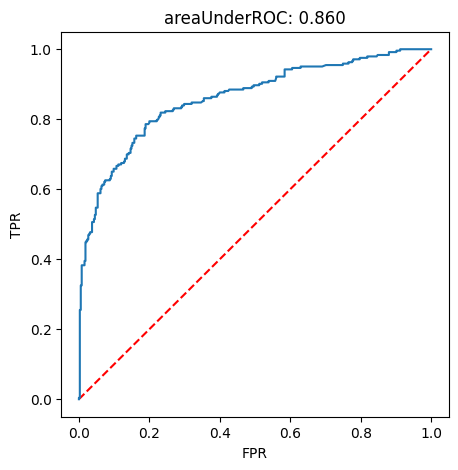

In [106]:
# Sol:
def roc(modelo):    
    trainingSummary= modelo.summary
    areaUnderROC = trainingSummary.areaUnderROC
    
    plt.figure(figsize=(5,5))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.plot(trainingSummary.roc.select('FPR').collect(),
             trainingSummary.roc.select('TPR').collect())
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    # Area bajo la curva:
    plt.title(f"areaUnderROC: {areaUnderROC:.3f}") 
    plt.show()
    
roc(trained_lrModel)

### Pregunta 9

¿Se te ocurre alguna explicación de por qué los datos para una clase son mejores que los de otra? 

Una frase debe valer

In [139]:
# Sol 
# Seguramente se deba a la cantidad de datos que hay en cada clase en el conjunto de entrenamiento.

### Pregunta 10

Queremos ahora repetir la pregunta 5 pero de forma que aseguremos que de media en el conjunto de entrenamiento haya tantos valores label 0 como 1. Para ello debemos "retocar" el test tras el `randomSplit` de la siguiente forma:

__a)__ Dividir el conjunto train en 2 dataframes, uno con todos las filas con la columna `label` a  0 y otro con todas las filas con label igual 1. Obtener el número de elementos de ambos conjuntos y calcular el mayor. Puedes usar `filter`. 

__b)__ Añadir filas al dataframe que menos tenga. para aquipararlo al otro dataframe. Para ello usaremos [sample](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.sample.html). Para añadir las nuevas filas se puede usar el método `union`. Comprobar que han quedado ambos dataframes con un número parecido de filas (no será el mismo, el método sample devuelve valores aproximados).

__c)__ Volver a unir los dos dataframes generando un dataframe `entrena2` que, ahora sí, está equilibrado, y repetir el resto del ejercicio 5 pero con `entrena2` como conjunto de entrenamiento (el test puede ser el mismo) y generando una predicciones `predicciones2`.

__d)__ Evalua los resultados

In [96]:
# Sol a :
# a)
train_0 = train.where(F.col("label_survived") == 0)
train_1 = train.where(F.col("label_survived") == 1)

print((train_0.count(),train_1.count(),train_1.count()/(train_1.count()+train_0.count())))

(375, 243, 0.3932038834951456)


In [100]:
# Sol b :
# b) 
train_1 = train_1.union(train_1.sample((train_0.count() -train_1.count())/train_0.count()))
print((train_0.count(),train_1.count()))

(375, 378)


In [102]:
# Sol c :
# c)
entrena2 = train_0.union(train_1)
lrModel_entrenado = lrModel.fit(entrena2)
predicciones = lrModel_entrenado.transform(test)

In [103]:
# Sol d:
# d)
mm2 = MulticlassMetrics(predicciones.select("prediction", "label_survived").rdd.map(tuple))
matriz_de_confusion_2 = mm2.confusionMatrix().toArray()

print(matriz_de_confusion_2)

/home/danrec/.local/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[132.  42.]
 [ 22.  77.]]


In [113]:
# Sol:
recall = [mm2.recall(0), mm2.recall(1)]
prec = [mm2.precision(0),mm2.precision(1)]
n = matriz_de_confusion_2.sum()
p_observed = sum(matriz_de_confusion_2[i, i] for i in range(matriz_de_confusion_2.shape[0])) / n
p_expected = sum((sum(matriz_de_confusion_2[i, :]) * sum(matriz_de_confusion_2[:, i])) / n for i in range(matriz_de_confusion_2.shape[0])) / n
kappa = (p_observed - p_expected) / (1 - p_expected)

print(recall)
print(prec)
print(kappa)

[0.7586206896551724, 0.7777777777777778]
[0.8571428571428571, 0.6470588235294118]
0.5140186915887849


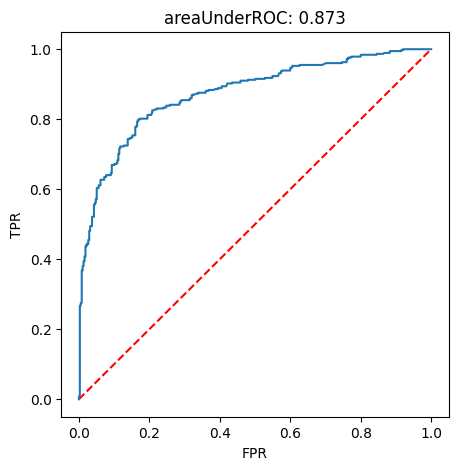

In [112]:
roc(lrModel_entrenado)